# Section3
https://github.com/PacktPublishing/Bayesian-Analysis-with-Python/blob/master/Chapter%203/03_Juggling%20with%20multiparametric%20and%20Hierarchical%20models.ipynb

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import Image

import os, sys, re, datetime, time
from pathlib import Path

from matplotlib import pyplot as plt
import japanize_matplotlib
import seaborn as sns
plt.style.use("bmh")
import numpy as np
import pandas as pd
import dask.dataframe as dd
from scipy import stats

from tqdm import tqdm_notebook

In [2]:
import pymc3 as pm

/Users/yutaro_ikeda/.pyenv/versions/3.6.5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (16, 4)
plt.rcParams["font.family"] = "IPAexGothic"
import logging
logging.basicConfig(level=logging.INFO)

In [4]:
data = np.array([51.06, 55.12, 53.73, 50.24, 52.05, 56.40, 48.45, 52.34, 55.65, 51.49, 51.86, 63.43, 53.00, 56.09, 51.93, 52.31, 52.33, 57.48, 57.44, 55.14, 53.93, 54.62, 56.09, 68.58, 51.36, 55.47, 50.73, 51.94, 54.95, 50.39, 52.91, 51.5, 52.68, 47.72, 49.73, 51.82, 54.99, 52.84, 53.19, 54.52, 51.46, 53.73, 51.61, 49.81, 52.42, 54.3, 53.84, 53.16])

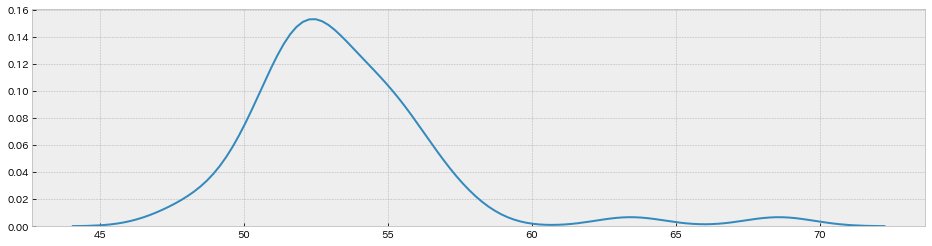

In [5]:
sns.kdeplot(data)

In [6]:
with pm.Model() as model:
    mu = pm.Uniform('mu', 40, 75)
    sigma = pm.HalfNormal('sigma', sd=10)
    y = pm.Normal('y', mu=mu, sd=sigma, observed=data)
    trace = pm.sample(1000, chains=1)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
NUTS: [sigma, mu]
INFO:pymc3:NUTS: [sigma, mu]
100%|██████████| 1500/1500 [00:01<00:00, 960.69it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc3:Only one chain was sampled, this makes it impossible to run some convergence checks


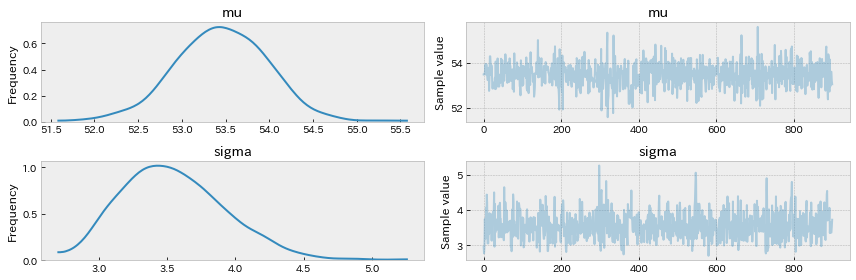

In [7]:
chain = trace[100:]
pm.traceplot(chain);

In [8]:
df = pm.summary(chain)

In [9]:
df

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mu,53.456139,0.531325,0.018449,52.303266,54.395024
sigma,3.548315,0.381142,0.014065,2.907611,4.291227


100%|██████████| 100/100 [00:00<00:00, 883.82it/s]


Text(0.5,0,'$x$')

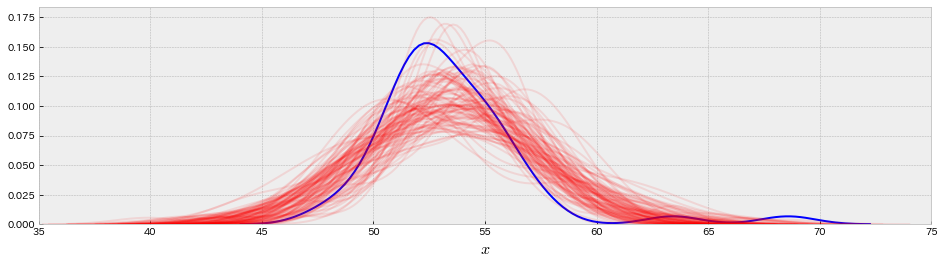

In [10]:
y_pred = pm.sample_ppc(chain, 100, model, size=len(data))
sns.kdeplot(data, color='b')

for i in y_pred['y']:
    sns.kdeplot(i[0], color='r', alpha=.1)
plt.xlim(35, 75)
plt.xlabel('$x$', fontsize=16)

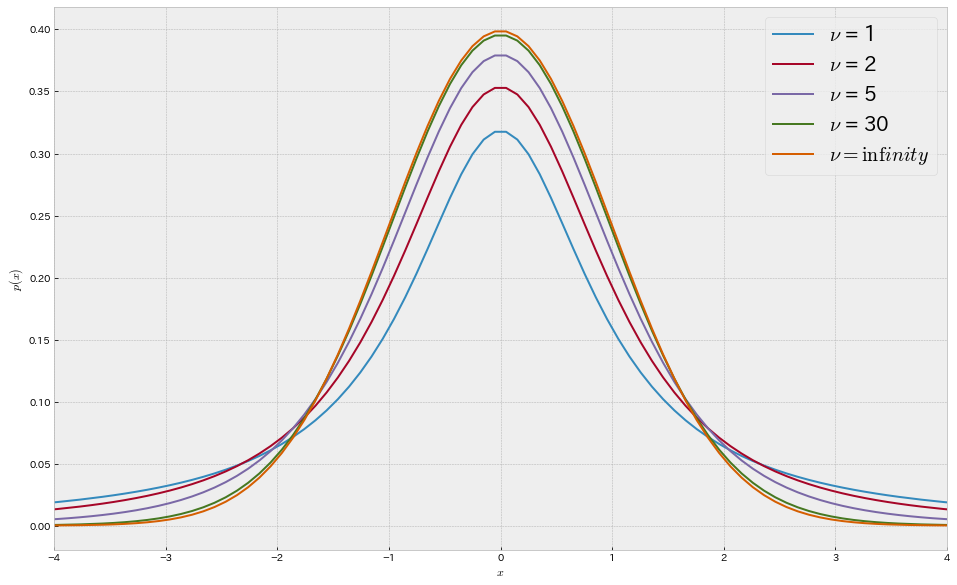

In [16]:
plt.figure(figsize=(16, 10))
x_vals = np.linspace(-10, 10, 200)
for df in [1, 2, 5, 30]:
    distri = stats.t(df)
    x_pdf = distri.pdf(x_vals)
    plt.plot(x_vals, x_pdf, label=rf'$\nu$ = {df}')
    
x_pdf = stats.norm.pdf(x_vals)
plt.plot(x_vals, x_pdf, label=r'$\nu = \infinity$')
plt.xlabel('$x$')
plt.ylabel('$p(x)$')
plt.xlim(-4, 4)
plt.legend(loc=0, fontsize=20)

In [18]:
with pm.Model() as model:
    mu = pm.Uniform('mu', 40, 75)
    sigma = pm.HalfNormal('sigma', sd=10)
    nu = pm.Exponential('nu', 1/30)
    y = pm.StudentT('y', mu=mu, sd=sigma, nu=nu, observed=data)
    trace = pm.sample(1100)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, sigma, mu]
INFO:pymc3:NUTS: [nu, sigma, mu]
Sampling 2 chains: 100%|██████████| 3200/3200 [00:02<00:00, 1574.24draws/s]


In [19]:
chain = trace[100:]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11433e860>,
      dtype=object)

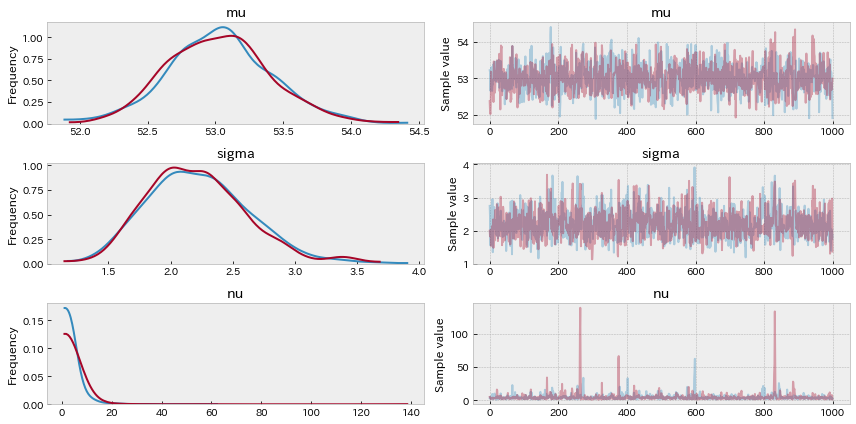

In [20]:
pm.traceplot(chain)

In [21]:
pm.summary(chain)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,53.023866,0.377441,0.011014,52.293973,53.786220,1232.695328,0.999641
sigma,2.213911,0.408767,0.012849,1.518572,3.061883,974.571142,0.999958
nu,5.024488,6.667673,0.238150,1.099015,11.453220,738.187918,0.999918


100%|██████████| 100/100 [00:00<00:00, 804.97it/s]


Text(0.5,1,"Student's t model")

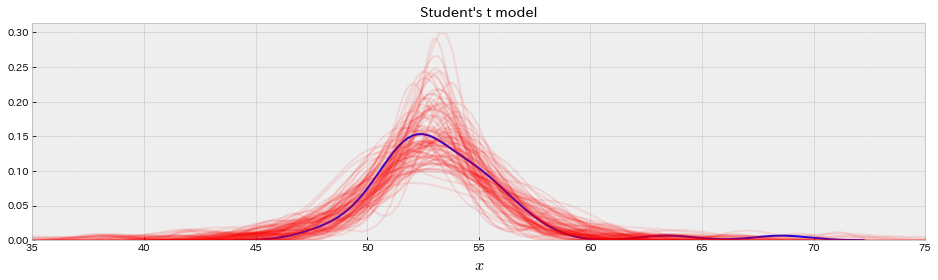

In [23]:
y_pred = pm.sample_ppc(chain, 100, model, size=len(data))
sns.kdeplot(data, color='b')

for i in y_pred['y']:
    sns.kdeplot(i[0], color='r', alpha=.1)
plt.xlim(35, 75)
plt.xlabel('$x$', fontsize=16)
plt.title("Student's t model")

# グループ間の比較

In [24]:
tips = sns.load_dataset('tips')

In [25]:
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


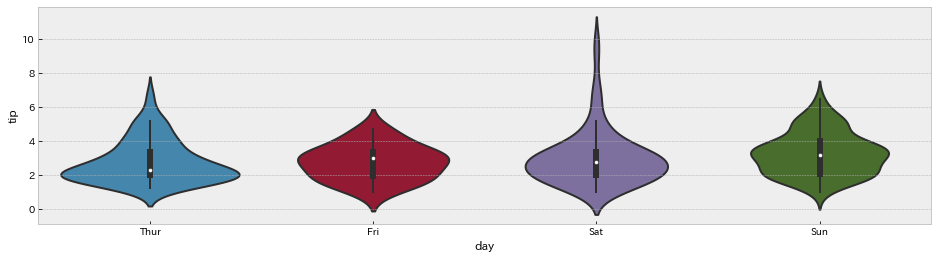

In [26]:
sns.violinplot(x='day', y='tip', data=tips)

In [36]:
y_val = tips['tip'].values
idx = pd.Categorical(tips['day']).codes

In [28]:
idx

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0], dtype=int8)

In [37]:
with pm.Model() as model:
    n_unq_idx = len(set(idx))
    means = pm.Normal('means', mu=0, sd=10, shape=n_unq_idx)
    sds = pm.HalfNormal('sds', sd=10, shape=n_unq_idx)
    
    y = pm.Normal('y', mu=means[idx], sd=sds[idx], observed=y_val)
    trace = pm.sample(5100, chains=1)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
NUTS: [sds, means]
INFO:pymc3:NUTS: [sds, means]
100%|██████████| 5600/5600 [00:12<00:00, 455.97it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc3:Only one chain was sampled, this makes it impossible to run some convergence checks


In [38]:
chain = trace[100::]

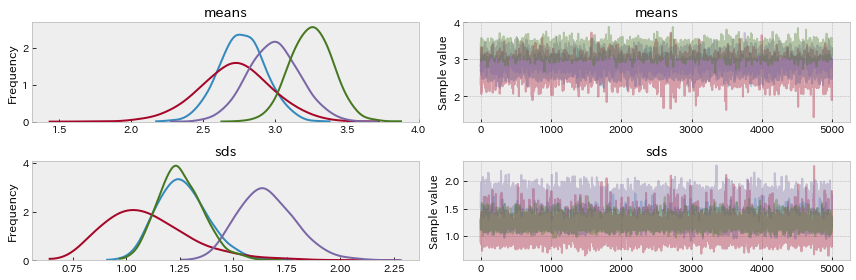

In [39]:
pm.traceplot(chain);

In [40]:
pm.summary(chain)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
means__0,2.773497,0.161013,0.002448,2.458422,3.089148
means__1,2.723921,0.255495,0.003671,2.214715,3.217789
means__2,2.992760,0.179940,0.002745,2.641508,3.347331
means__3,3.254900,0.149048,0.002086,2.961233,3.537206
sds__0,1.264893,0.118698,0.001899,1.057514,1.514056
sds__1,1.103904,0.203325,0.003103,0.750889,1.494346
sds__2,1.657799,0.133676,0.001722,1.404626,1.917164
sds__3,1.255310,0.104666,0.001469,1.054342,1.457961


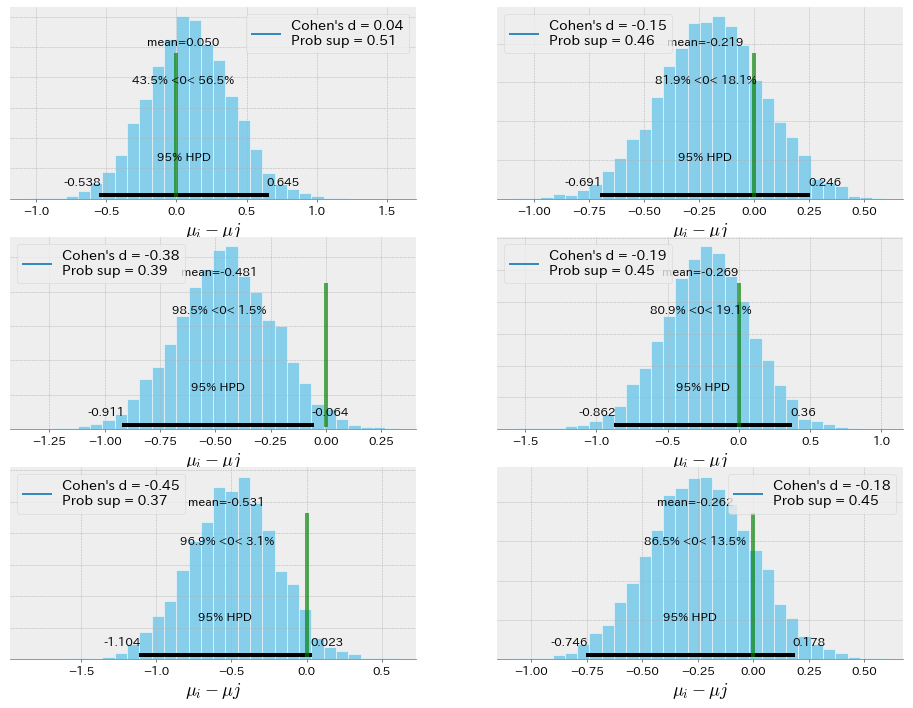

In [54]:
dist = stats.norm()
_, ax = plt.subplots(3, 2, figsize=(16, 12))

comparisons = [(i, j) for i in range(4) for j in range(i+1, 4)]
pos = [(k, l) for k in range(3) for l in (0, 1)]

for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = chain['means'][:, i] - chain['means'][:, j]
    d_cohen = (
        means_diff / np.sqrt(
            (
                chain['sds'][:, i]**2 + chain['sds'][:, j]**2
            ) / 2)
    ).mean()
    ps = dist.cdf(d_cohen / (2**0.5))
    
    pm.plot_posterior(means_diff, ref_val=0, ax=ax[k, l], color='skyblue')
    ax[k, l].plot(0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}")
    
    ax[k, l].set_xlabel('$\mu_{i}-\mu{j}$', fontsize=18)
    ax[k, l].legend(loc=0, fontsize=14)
    

# 階層モデル

In [72]:
N_samples = [30, 30, 30]
G_samples = [18, 18, 18]

group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1,0], [G_samples[i], N_samples[i]-G_samples[i]]))

In [73]:
with pm.Model() as model:
    alpha = pm.HalfCauchy('alpha', beta=10)
    beta = pm.HalfCauchy('beta', beta=10)
    theta = pm.Beta('theta', alpha, beta, shape=len(N_samples))
    y = pm.Bernoulli('y', p=theta[group_idx], observed=data)
    
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, beta, alpha]
INFO:pymc3:NUTS: [theta, beta, alpha]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:06<00:00, 728.94draws/s] 
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 149 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 149 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


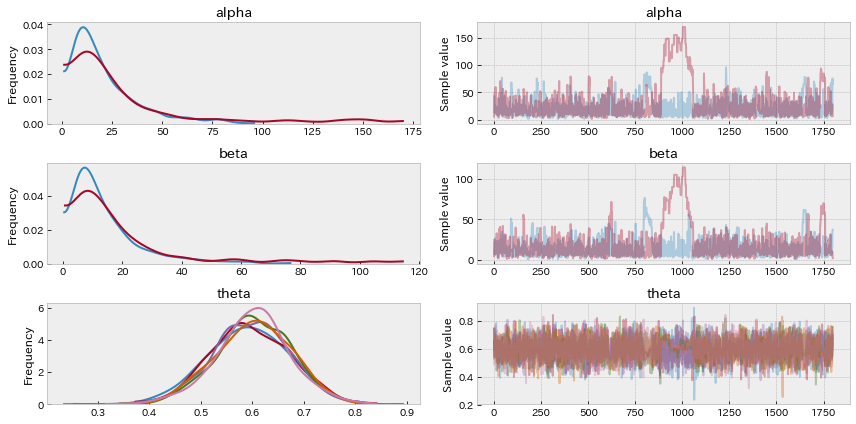

In [74]:
chain = trace[200:]
pm.traceplot(chain);

Text(0.5,0,'$\\theta_{prior}$')

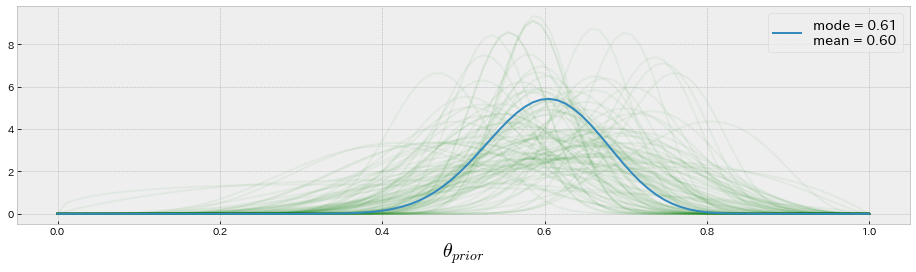

In [76]:
x = np.linspace(0, 1, 100)
for i in np.random.randint(0, len(chain), size=100):
    pdf = stats.beta(chain['alpha'][i], chain['beta'][i]).pdf(x)
    plt.plot(x, pdf, 'g', alpha=.05)
    
dist = stats.beta(chain['alpha'].mean(), chain['beta'].mean())
pdf = dist.pdf(x)
mode = x[np.argmax(pdf)]
mean = dist.moment(1)
plt.plot(x, pdf, label=f'mode = {mode:.2f}\nmean = {mean:.2f}')

plt.legend(fontsize=14)
plt.xlabel(r'$\theta_{prior}$', fontsize=20)

# 演習1

In [77]:
data = np.array([51.06, 55.12, 53.73, 50.24, 52.05, 56.40, 48.45, 52.34, 55.65, 51.49, 51.86, 63.43, 53.00, 56.09, 51.93, 52.31, 52.33, 57.48, 57.44, 55.14, 53.93, 54.62, 56.09, 68.58, 51.36, 55.47, 50.73, 51.94, 54.95, 50.39, 52.91, 51.5, 52.68, 47.72, 49.73, 51.82, 54.99, 52.84, 53.19, 54.52, 51.46, 53.73, 51.61, 49.81, 52.42, 54.3, 53.84, 53.16])

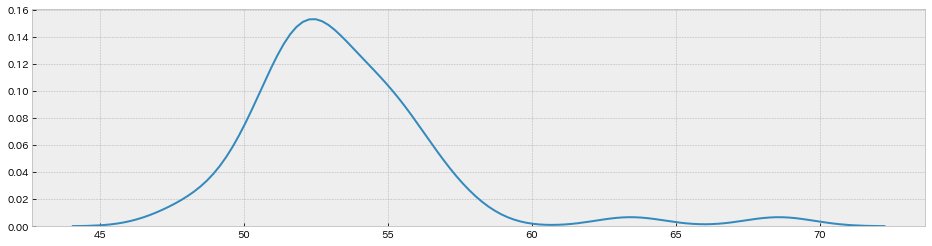

In [83]:
sns.kdeplot(data)

In [78]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=data.mean(), sd=data.std())
    sigma = pm.HalfNormal('sigma', sd=10)
    y = pm.Normal('y', mu=mu, sd=sigma, observed=data)
    trace = pm.sample(1000, chains=1)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
NUTS: [sigma, mu]
INFO:pymc3:NUTS: [sigma, mu]
100%|██████████| 1500/1500 [00:01<00:00, 1422.12it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc3:Only one chain was sampled, this makes it impossible to run some convergence checks


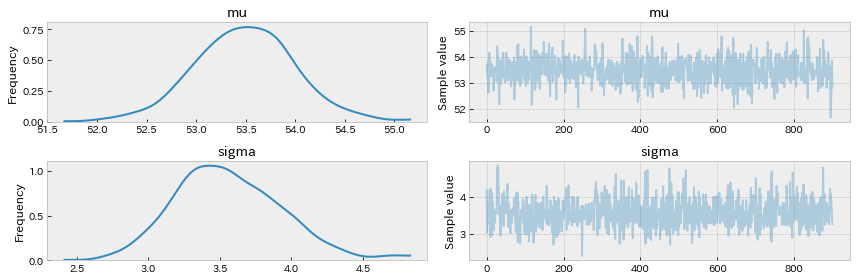

In [79]:
chain = trace[100:]
pm.traceplot(chain);

In [81]:
pm.summary(chain)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mu,53.488750,0.499988,0.016289,52.568418,54.583004
sigma,3.557654,0.371861,0.013378,2.897478,4.301685


# 演習2

In [84]:
data = np.array([51.06, 55.12, 53.73, 50.24, 52.05, 56.40, 48.45, 52.34, 55.65, 51.49, 51.86, 63.43, 53.00, 56.09, 51.93, 52.31, 52.33, 57.48, 57.44, 55.14, 53.93, 54.62, 56.09, 68.58, 51.36, 55.47, 50.73, 51.94, 54.95, 50.39, 52.91, 51.5, 52.68, 47.72, 49.73, 51.82, 54.99, 52.84, 53.19, 54.52, 51.46, 53.73, 51.61, 49.81, 52.42, 54.3, 53.84, 53.16])

In [85]:
data.shape

(48,)

In [88]:
data[24] = 100
data[30] = 80
data[3] = 0

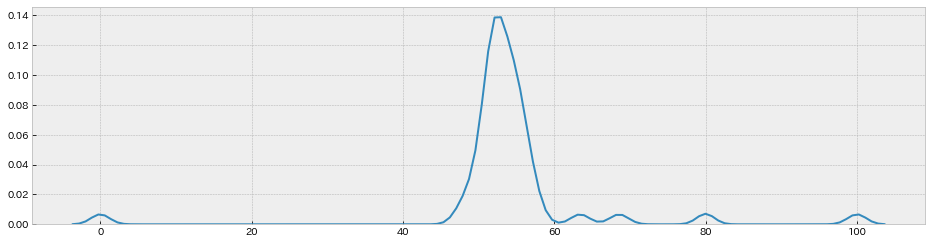

In [89]:
sns.kdeplot(data)

In [90]:
with pm.Model() as model:
#     mu = pm.Normal('mu', mu=data.mean(), sd=data.std())
    mu = pm.Uniform('mu', 40, 75)
    sigma = pm.HalfNormal('sigma', sd=10)
    y = pm.Normal('y', mu=mu, sd=sigma, observed=data)
    trace = pm.sample(1000, chains=1)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
NUTS: [sigma, mu]
INFO:pymc3:NUTS: [sigma, mu]
100%|██████████| 1500/1500 [00:01<00:00, 1473.93it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc3:Only one chain was sampled, this makes it impossible to run some convergence checks


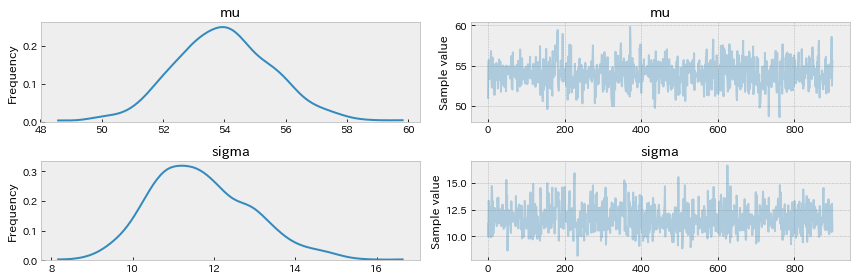

In [91]:
chain = trace[100:]
pm.traceplot(chain);

## 外れ値がないバージョン

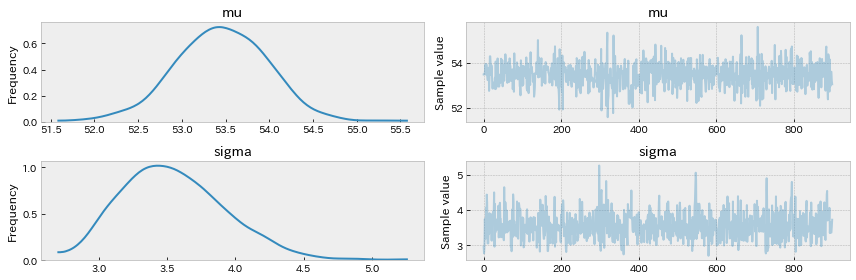

In [7]:
chain = trace[100:]
pm.traceplot(chain);